## Tweet project Part 2

#### 1. Create score for identifying influential twitterers - weight the retweets differently
#### 2. Classify the influential twitterers
#### 3. Visualise the distribution of tweets / retweets in organisations


In [2]:
import sys
print(sys.version)
print(spark.version)

3.8.13 | packaged by conda-forge | (default, Mar 25 2022, 06:04:10) 
[GCC 10.3.0]
3.1.3


In [3]:
import os
import time
import subprocess

from pyspark.sql.functions import *
from pyspark.sql.types import *

from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [4]:
warnings.filterwarnings(action='ignore')
spark = SparkSession.builder.getOrCreate()

##Add "eagerEval.enabled" to beautify the way Spark DF is displayed
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

## To use legacy casting notation for date
spark.conf.set("spark.sql.legacy.timeParserPolicy","LEGACY")

In [4]:
## Read processed data
bucket_name = 'prayutjain-tweet-bucket'
prefix = 'processed_data'

df = spark.read.parquet('gs://' + bucket_name + '/' + prefix + '/')

22/12/06 18:57:07 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [6]:
df.printSchema()

root
 |-- user_created_at: timestamp (nullable = true)
 |-- user_description: string (nullable = true)
 |-- user_favourites_count: long (nullable = true)
 |-- user_followers_count: long (nullable = true)
 |-- user_friends_count: long (nullable = true)
 |-- user_id_str: string (nullable = true)
 |-- user_name: string (nullable = true)
 |-- user_protected: boolean (nullable = true)
 |-- user_screen_name: string (nullable = true)
 |-- user_statuses_count: long (nullable = true)
 |-- user_verified: boolean (nullable = true)
 |-- user_withheld_in_countries: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- user_location: string (nullable = true)
 |-- tweet_coordinates: struct (nullable = true)
 |    |-- coordinates: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |    |-- type: string (nullable = true)
 |-- tweet_created_at: timestamp (nullable = true)
 |-- tweet_id_str: string (nullable = true)
 |-- tweet_lang: string (nullable = tru

## 1. Create scores for each user

In [9]:
df\
.filter(df['user_verified'] == True)\
.select('favorite_count','retweet_count','reply_count','quote_count','user_followers_count')\
.describe()

summary,favorite_count,retweet_count,reply_count,quote_count,user_followers_count
count,238622,238622,238622,238622,631648
mean,2397.0612935940526,463.7141965116377,60.96319283217809,49.4121288062291,266670.0650203911
stddev,17375.092003999693,2985.9402016911863,501.5996379212643,427.25044477648703,1688299.0453588753
min,0,1,0,0,0
max,1152165,120705,28078,63503,132048115


In [7]:
## Step 1 - First create a score for each tweet, how influential the tweet is

df_influencer = df\
.withColumn('popularity', df.favorite_count / df.user_followers_count)\
.withColumn('relevance', (df.reply_count + df.quote_count + df.retweet_count)\
            /(df.reply_count + df.quote_count + df.retweet_count + df.favorite_count))\
.withColumn('if_retweet', when(df.tweet_retweeted_status.isNull(), False).otherwise(True))

## Step 2 - Then aggregate a score for each user on the basis of their score - calling it the influence score of the user

df_influencer1 = df_influencer\
.groupBy('user_id_str','if_retweet')\
.agg(count('*').alias('total_count'),
     avg('retweet_count').alias('avg_retweet'),
     sum('retweet_count').alias('total_retweet'),
     max('user_followers_count').alias('followers_count'),
     avg('popularity').alias('popularity_score'),
     avg('relevance').alias('relevance_score'))

df_joined = df.select('user_id_str','user_name','user_screen_name','user_description','user_verified','user_location')\
.dropDuplicates(['user_id_str'])\
.join(df_influencer1,"user_id_str","left")\
.withColumn('user_description1', lower('user_description'))





## 2. Classify the twitterers

In [ ]:
org_news = ['journal','times','daily','News','news']
org_news1='|'.join(["(" + c +")" for c in org_news])

org_govt = ['republic','congress','parliament','senat','president','democr',
            'prime minister','consti','MLA','mla','gov','u.s.','U.S.','US','united states']
org_govt1='|'.join(["(" + c +")" for c in org_govt])

org_celeb = ['actor','singer','writer','musician','actress','author','golfer']
org_celeb1='|'.join(["(" + c +")" for c in org_celeb])

org_edu = ['school','School','university','University','research','teaching','edu','college','master',
           'graduate','undergraduate','elementary','Learning']
org_edu1='|'.join(["(" + c +")" for c in org_edu])

org_nonprofit = ['nonprofit organisation']
org_nonprofit1='|'.join(["(" + c +")" for c in org_nonprofit])

df_org = df_joined\
.withColumn('Organisation',\
            when(df_joined['user_verified'] == False, 'Other')\
           .when((df_joined['user_name'].rlike(org_news1)) | (df_joined['user_description1'].rlike(org_news1)), 'news')\
           .when((df_joined['user_name'].rlike(org_govt1)) | (df_joined['user_description1'].rlike(org_govt1)), 'govt')\
           .when((df_joined['user_description1'].rlike(org_celeb1)) & (df_joined['followers_count'] > 25000), 'celeb')\
           .when((df_joined['user_name'].rlike(org_edu1)) | (df_joined['user_description1'].rlike(org_edu1)), 'edu_institute')\
           .when((df_joined['user_name'].rlike(org_nonprofit1)) | (df_joined['user_description1'].rlike(org_nonprofit1)), 'nonprofit')\
           .when(df_joined['followers_count'] > 10000, 'influencer')\
           .otherwise('Other'))\
.drop('user_description1')

df_org.show(5)

In [ ]:
bucket_name = 'prayutjain-tweet-bucket'
prefix = 'influencers'

df_org.write.format("parquet").\
mode('overwrite').\
save('gs://' + bucket_name + '/' + prefix + '/')

### 2.1 Identify the most influential twitterers

In [5]:
## Read influencers data
bucket_name = 'prayutjain-tweet-bucket'
prefix = 'influencers'

df_org = spark.read.parquet('gs://' + bucket_name + '/' + prefix + '/')

In [ ]:
df_org.filter((df_org['user_verified'] == True) & (df_org['if_retweet'] == False))\
.orderBy('total_count',ascending = False).show(5, truncate=False)
df_org.filter((df_org['user_verified'] == True) & (df_org['if_retweet'] == True) & (df_org['total_count'] > 100))\
.orderBy('avg_retweet',ascending = False).show(5, truncate=False)
#df_org.filter((df_org['user_verified'] == True) & (df_org['if_retweet'] == False))\
#.orderBy('relevance_score',ascending = False).show(5, truncate=False)
#df_org.filter((df_org['user_verified'] == True) & (df_org['if_retweet'] == False))\
#.orderBy('followers_count',ascending = False).show(5, truncate=False)

+-----------+-----------------------+----------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------+----------------+----------+-----------+-----------+-------------+---------------+----------------+---------------+-------------+
|user_id_str|user_name              |user_screen_name|user_description                                                                                                                                              |user_verified|user_location   |if_retweet|total_count|avg_retweet|total_retweet|followers_count|popularity_score|relevance_score|Organisation |
+-----------+-----------------------+----------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------+----------------+----------+-----------+-----------+-------

22/12/06 19:30:10 WARN org.apache.spark.deploy.yarn.YarnAllocator: Container from a bad node: container_1670348985571_0004_01_000029 on host: hub-msca-bdp-dphub-students-backup-prayutjain-sw-xfss.c.msca-bdp-students.internal. Exit status: 143. Diagnostics: [2022-12-06 19:30:09.942]Container killed on request. Exit code is 143
[2022-12-06 19:30:09.943]Container exited with a non-zero exit code 143. 
[2022-12-06 19:30:09.949]Killed by external signal
.
22/12/06 19:30:10 WARN org.apache.spark.deploy.yarn.YarnAllocator: Container from a bad node: container_1670348985571_0004_01_000032 on host: hub-msca-bdp-dphub-students-backup-prayutjain-sw-xfss.c.msca-bdp-students.internal. Exit status: 143. Diagnostics: [2022-12-06 19:30:09.943]Container killed on request. Exit code is 143
[2022-12-06 19:30:09.949]Container exited with a non-zero exit code 143. 
[2022-12-06 19:30:09.962]Killed by external signal
.
22/12/06 19:30:10 WARN org.apache.spark.scheduler.cluster.YarnSchedulerBackend$YarnSchedul

+-----------+----------------+----------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------+--------------------------+----------+-----------+------------------+-------------+---------------+--------------------+-------------------+-------------+
|user_id_str|user_name       |user_screen_name|user_description                                                                                                                                                |user_verified|user_location             |if_retweet|total_count|avg_retweet       |total_retweet|followers_count|popularity_score    |relevance_score    |Organisation |
+-----------+----------------+----------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------+------------------------

The top 5 influencers by tweet volume are:
1. 19616718   |U.S. News Education    
2. 19675956   |ExploreLearning
3. 78874095   |Tes
4. 1276140426 |Corey A. DeAngelis
5. 113388430  |Student Finance England

The top 5 influencers by average retweet count on their posts



## 3. Visualise the tweet / retweet distribution 

In [9]:
df_org = df_org.na.fill(value='Other',subset=['Organisation'])

df_ver = df_org.filter((df_org['user_verified'] == True)).select('Organisation','user_id_str','total_count','total_retweet')

plt1 = df_ver.groupBy('Organisation').agg(sum('total_count').alias('total_tweets')).toPandas()
plt2 = df_ver.groupBy('Organisation').agg(avg('total_retweet').alias('avg_retweets')).toPandas()


<AxesSubplot:title={'center':'Total tweets by organisation'}, xlabel='Organisation'>

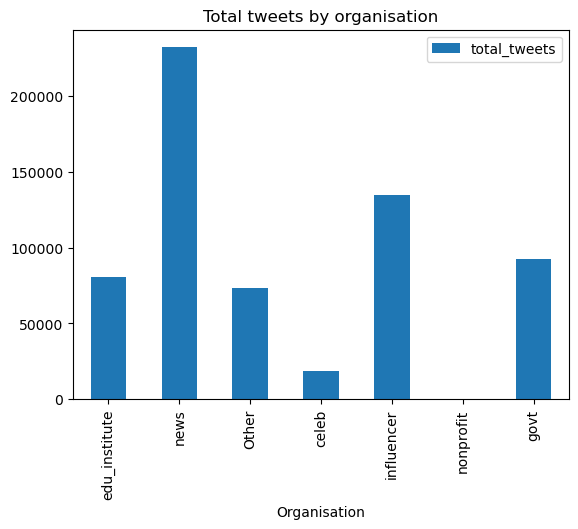

In [13]:
plt1.plot(kind='bar',x='Organisation', title = 'Total tweets by organisation')

<AxesSubplot:title={'center':'Average retweets per organisation'}, xlabel='Organisation'>

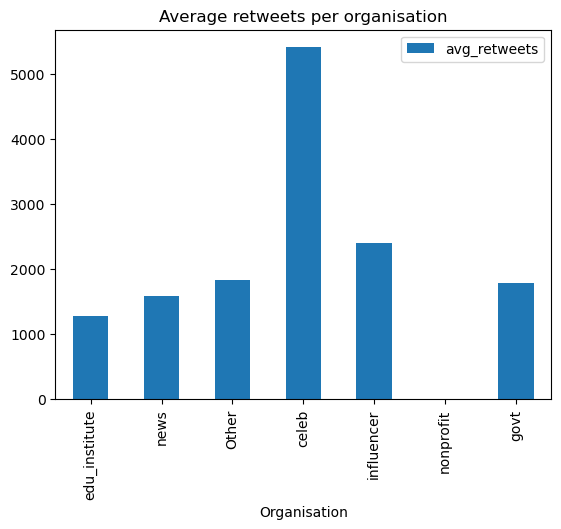

In [14]:
plt2.plot(kind='bar', x='Organisation', title='Average retweets per organisation')

In [28]:
df_inf = df_org.filter((df_org['user_verified'] == True) & (df_org['if_retweet'] == False))\
.orderBy('total_count',ascending = False).limit(100).select('user_id_str','Organisation','total_count','total_retweet')

df_inf_rt = df_org.filter((df_org['user_verified'] == True) & (df_org['if_retweet'] == True) & (df_org['total_count'] > 100))\
.orderBy('avg_retweet',ascending = False).limit(100).select('user_id_str','Organisation','total_count','total_retweet','avg_retweet')

df_inf_1 = df_inf.groupBy('Organisation').agg(sum('total_count').alias('total_tweets')).toPandas()
df_inf_rt_1 = df_inf_rt.groupBy('Organisation').agg(avg('total_retweet').alias('avg_total_retweets')).toPandas()


<AxesSubplot:title={'center':'Total tweets by organisation (Top 100 influencers by tweet vol)'}, xlabel='Organisation'>

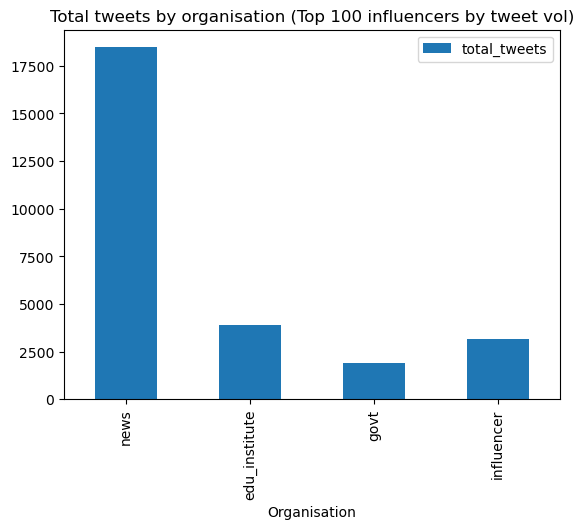

In [22]:
df_inf_1.plot(kind='bar',x='Organisation', title = 'Total tweets by organisation (Top 100 influencers by tweet vol)')

<AxesSubplot:title={'center':'Average retweets by organisation (Top 100 influencers by avg retweet)'}, xlabel='Organisation'>

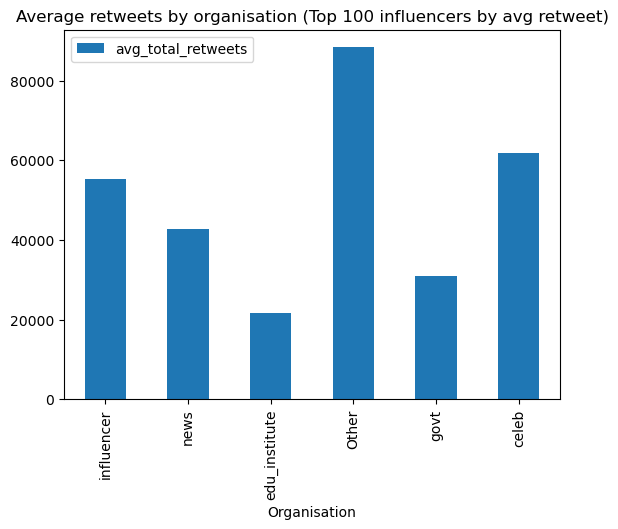

22/12/08 02:45:58 WARN org.apache.spark.scheduler.cluster.YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 19 for reason Container marked as failed: container_1670438604801_0005_01_000019 on host: hub-msca-bdp-dphub-students-backup-prayutjain-sw-jj5k.c.msca-bdp-students.internal. Exit status: -100. Diagnostics: Container released on a *lost* node.
22/12/08 02:45:58 WARN org.apache.spark.scheduler.cluster.YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 18 for reason Container marked as failed: container_1670438604801_0005_01_000018 on host: hub-msca-bdp-dphub-students-backup-prayutjain-sw-jj5k.c.msca-bdp-students.internal. Exit status: -100. Diagnostics: Container released on a *lost* node.
22/12/08 02:45:58 ERROR org.apache.spark.scheduler.cluster.YarnScheduler: Lost executor 18 on hub-msca-bdp-dphub-students-backup-prayutjain-sw-jj5k.c.msca-bdp-students.internal: Container marked as failed: container_1670438604801_0005_0

In [29]:
df_inf_rt_1.plot(kind='bar',x='Organisation', title = 'Average retweets by organisation (Top 100 influencers by avg retweet)')